# Investigate Breitbart dbpedia tags

This notebook runs the "lead" fields from Brietbart news articles through a dbpedia spotlight endpoint (check out http://dbpedia-spotlight.github.io) and collects the linked tags associated with each article.  Towards the end of the notebook I do two things with the tag, first I just plot a heatmap showing co-occurence of the tags and second I collect tags per author.  Since each article is associated with some tags, you can pivot this data on any article metadata you want (publication date, authors etc.).  Could be a lot of interesting analysis that comes out of this, especially if it's tied into other data sets.

In [83]:
import requests
import json
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors

metrics = defaultdict(float)  # perf measurements

# use this function to run dbpedia spotlight on some text and get back dbpedia URIs
def dbpedia_spotlight(text, confidence, blacklist_types=[], sim_threshold=0):
    t0 = time.time()
    url = "http://spotlight.sztaki.hu:2222/rest/annotate"
    try:
        r = requests.get(url, params={ 
                'text': text,
                'support': 20,
                'confidence': confidence
            }, headers={'Accept': 'application/json'}, timeout=5)
    except requests.exceptions.Timeout:
        metrics['request_get'] += time.time() - t0
        print "timed out"
        return []
    
    metrics['request_get'] += time.time() - t0
    try:
        result = r.json()
    except:
        print "no response for text: %s" % text
        return []
    dbpedia_resources = []
    if 'Resources' not in result: return []
    for resource in result['Resources']:
        if float(resource['@similarityScore']) < sim_threshold: continue
        resource_types = [ r.lower() for r in resource['@types'].split(',') ]
        if len(set(blacklist_types).intersection(set(resource_types))) == 0:
            dbpedia_resources.append(resource)
    return dbpedia_resources

In [84]:
file_path = "/mnt/sda1/Datasets/D4D/assemble/breitbart/hist_natsec.json"  # any of the breitbart docs will work
posts = []
with open(file_path, 'r') as fin:
    posts = json.load(fin)
    
print len(posts)
posts_df = pd.DataFrame(posts)

32359


In [96]:
# this dictionary is keyed by tags and has a list of post indices as values
direct_tags = defaultdict(list)
# this dictionary is keyed by post index and has a list of tags
content_resources = defaultdict(list)

# WARNING: This takes time for a full run!  Each of the 32k posts will be sent to a server for annotation.  
# If you'd like, you can run dbpedia spotlight locally (there's a docker container as well).
# The results below are from a run on the first 100 articles only
for idx, title in enumerate(posts_df['lead'][:100]):
    dbpedia_resources = dbpedia_spotlight(title, 0.35)
    for resource in dbpedia_resources:
        content_resources[idx].append(resource)
        direct_tags[resource['@URI']].append(idx)

no response for text:  
no response for text:  
no response for text:  
no response for text:  
no response for text:  
no response for text:  
no response for text:  
no response for text:  


In [97]:
# sort by number of articles the tag appears in
sorted_tags = sorted(direct_tags.keys(), key=lambda x: len(direct_tags[x]), reverse=True)

In [98]:
# check out the top 50 tags by article count
for t in sorted_tags[:50]:
    print t, len(direct_tags[t])

# build co-occurence matrix of top 50 tags
co_occuring_tags = []
idx = 0
for t1 in sorted_tags[:50]:
    row = []
    # filtering out bad tags ("The Times" was being tagged as New York Times which was rarely correct)
    if t1 in ["http://dbpedia.org/resource/The_New_York_Times", 
              "http://dbpedia.org/resource/-elect"] : continue
    for t2 in sorted_tags[:50]:
        if t2 in ["http://dbpedia.org/resource/The_New_York_Times", 
              "http://dbpedia.org/resource/-elect"] : continue
        s1 = set(direct_tags[t1])
        s2 = set(direct_tags[t2])
        if t1 == t2: 
            row.append(0.)
        else:
            # appending (2*intersection of set1 and set2) / (size of set1 + size of set2)
            row.append(float(2*len(s1.intersection(s2))) / float(len(s1)+len(s2)))
    co_occuring_tags.append(row)

http://dbpedia.org/resource/Russia 20
http://dbpedia.org/resource/Israel 19
http://dbpedia.org/resource/Barack_Obama 16
http://dbpedia.org/resource/United_States 16
http://dbpedia.org/resource/President_of_the_United_States 15
http://dbpedia.org/resource/Istanbul 11
http://dbpedia.org/resource/Jerusalem 10
http://dbpedia.org/resource/Nightclub 9
http://dbpedia.org/resource/John_Kerry 9
http://dbpedia.org/resource/New_Year 9
http://dbpedia.org/resource/Islamism 8
http://dbpedia.org/resource/Islam 8
http://dbpedia.org/resource/Islamic_State_of_Iraq_and_the_Levant 7
http://dbpedia.org/resource/Hacker_(computer_security) 7
http://dbpedia.org/resource/United_States_Department_of_Homeland_Security 6
http://dbpedia.org/resource/Turkey 6
http://dbpedia.org/resource/Donald_Trump 6
http://dbpedia.org/resource/United_Nations 5
http://dbpedia.org/resource/Syria 5
http://dbpedia.org/resource/Democratic_Party_(United_States) 4
http://dbpedia.org/resource/West_Bank 4
http://dbpedia.org/resource/Reute

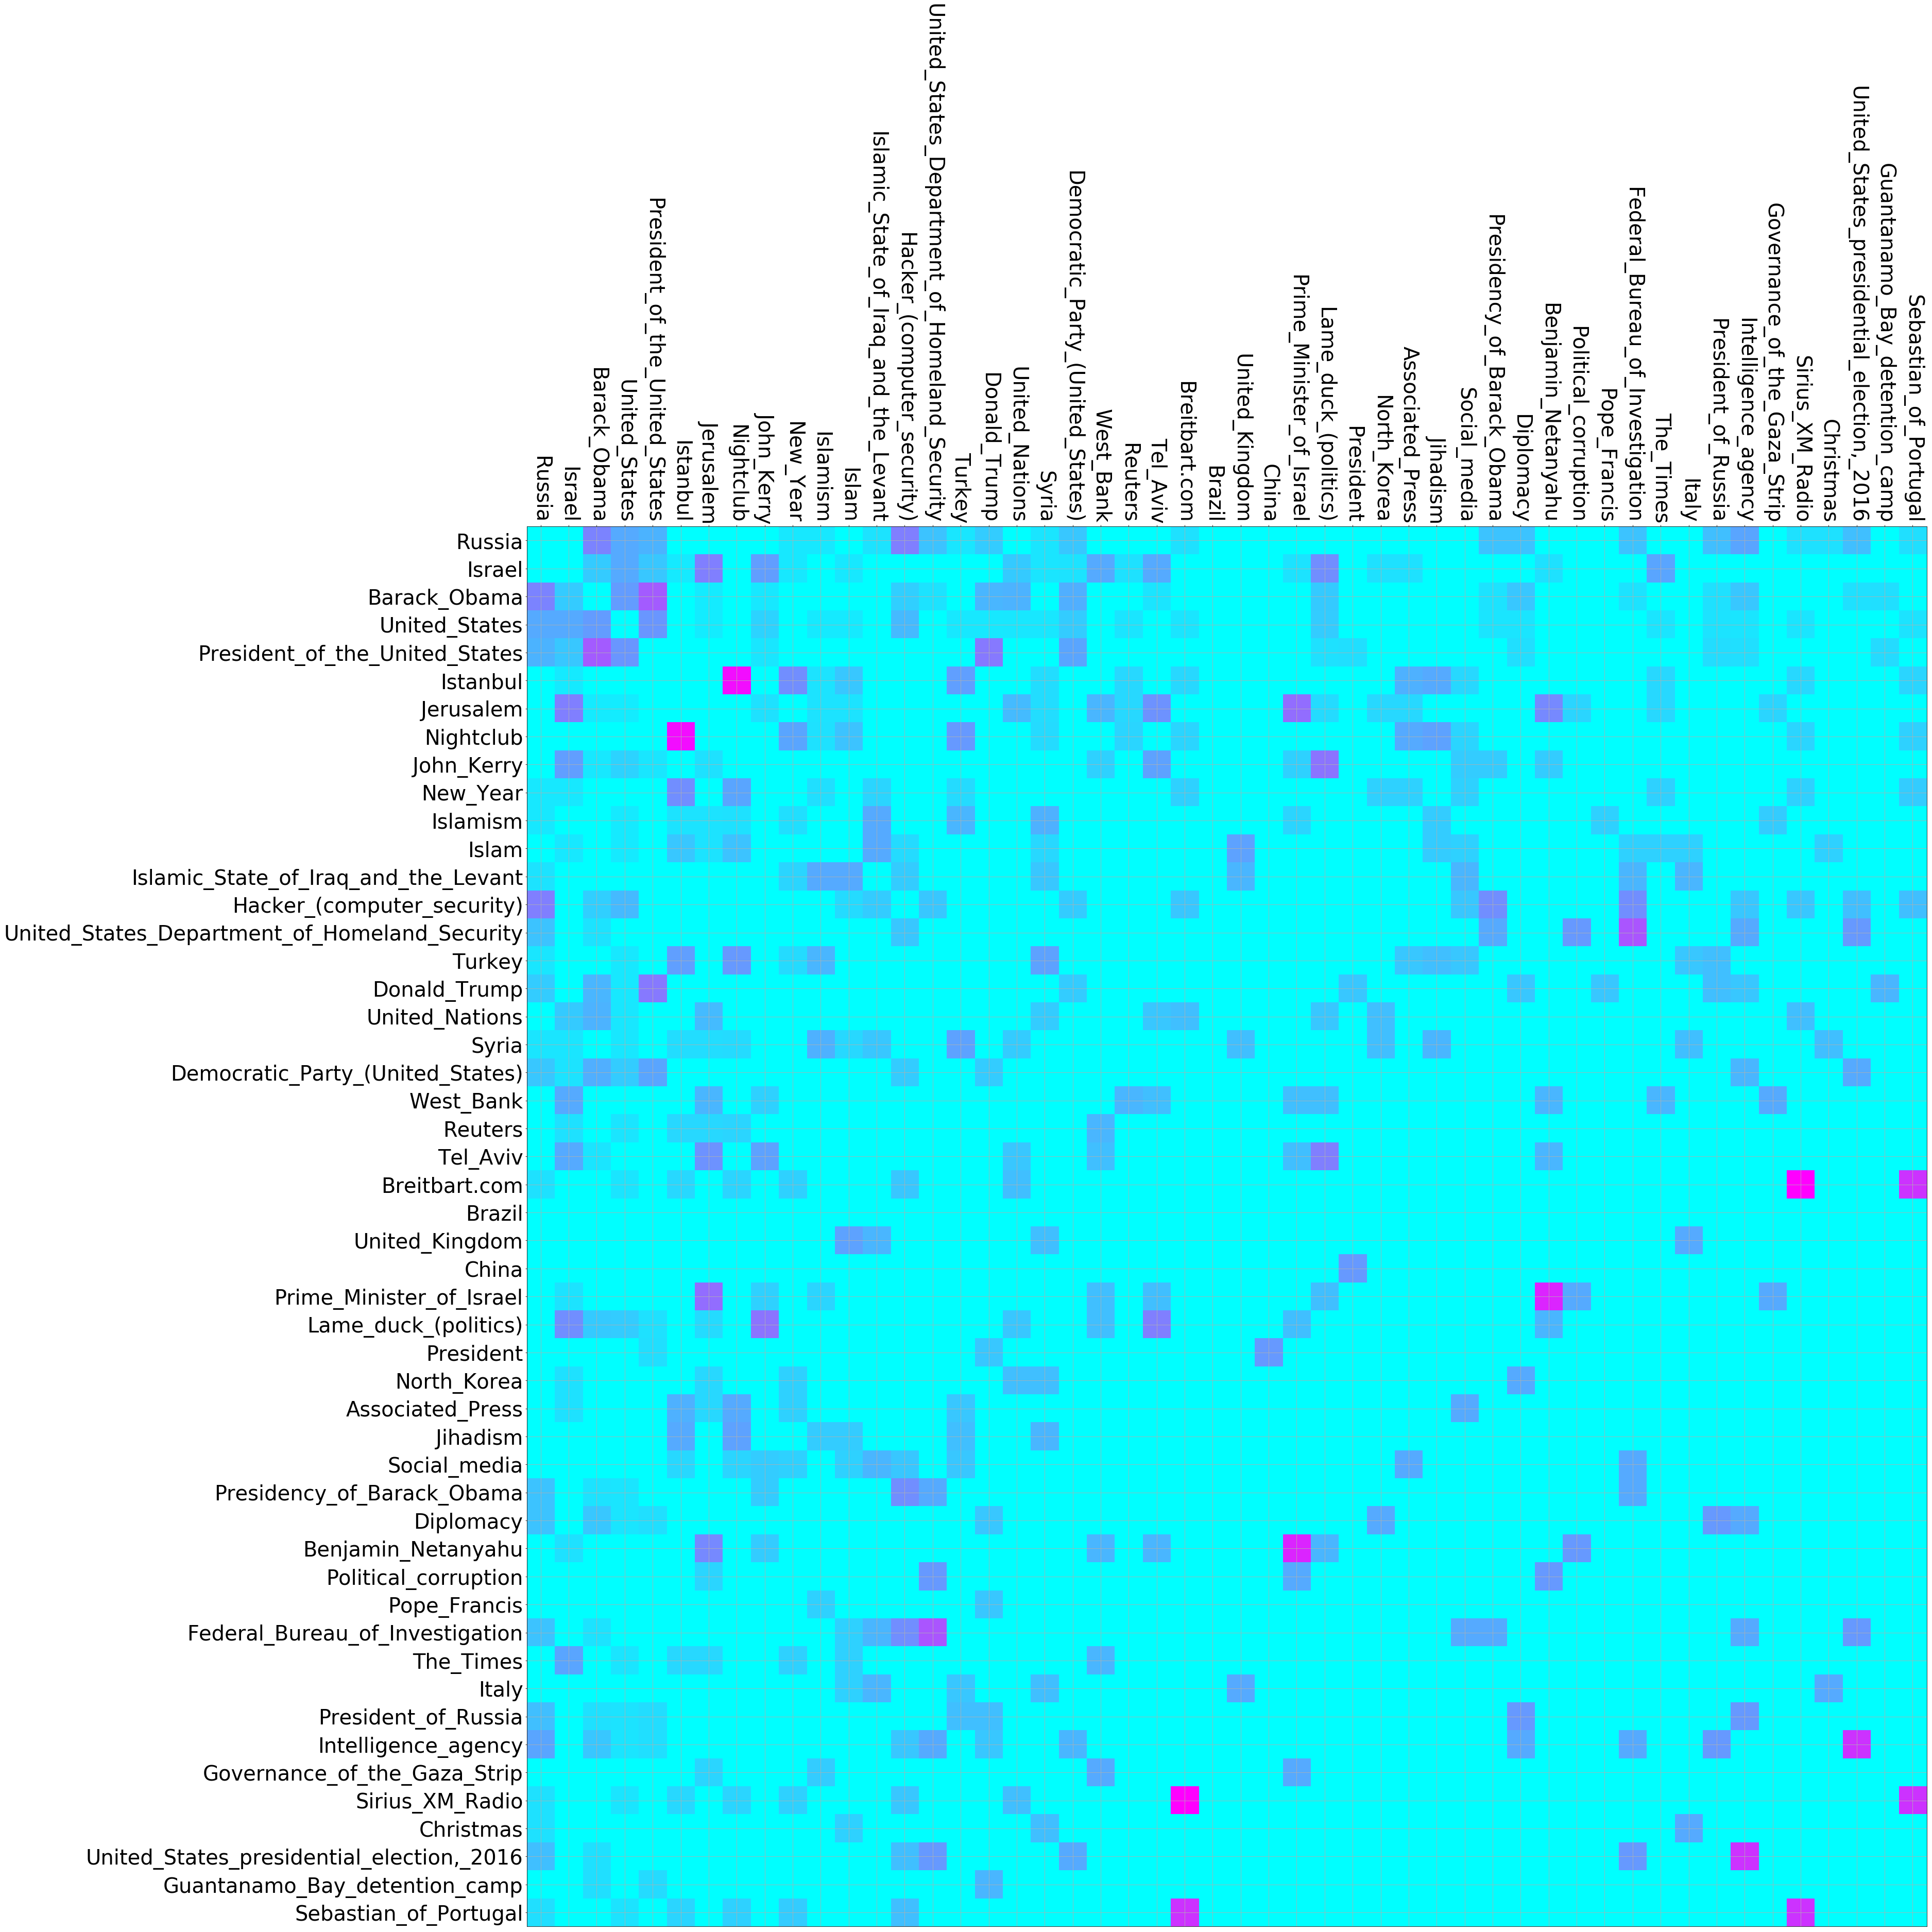

In [99]:
np.set_printoptions(suppress=True)
plt.rcParams['figure.figsize'] = (150.0, 150.0)

%matplotlib inline

plt.rcParams['figure.figsize'] = (50.0, 50.0)
ax = plt.imshow(np.array(co_occuring_tags), interpolation='nearest', cmap='cool', vmin=0, vmax=1).axes

m = len(co_occuring_tags)
n = m
_ = ax.set_xticks(np.linspace(0, n-1, n))
_ = ax.set_xticklabels([ x.split('/')[-1] for x in sorted_tags[:50]], fontsize=40, rotation=-90)
_ = ax.set_yticks(np.linspace(0, m-1, m))
_ = ax.set_yticklabels([ x.split('/')[-1] for x in sorted_tags[:50]], fontsize=40)

ax.grid('on')
ax.xaxis.tick_top()

In [100]:
def map_tags_to_field(tags_dict, data_frame, field):
    """
    Pivot function.  Returns a dict keyed by the field values
    with values equal to the tags mentioned.
    """
    pivot_dict = defaultdict(list)
    for tag, indices in tags_dict.iteritems():
        for idx in indices:
            field_value = data_frame.loc[idx][field]
            pivot_dict[field_value].append(tag)            
    return pivot_dict

def filter_dict(d, intersect):
    """
    Filter all values of the dict by intersecting with intersect.  Assumes d is a dict of lists.
    """
    for k, v in d.iteritems():
        d[k] = list(set(v).intersection(set(intersect)))
    return d

In [101]:
# pivot the tag data using the data frame and build a dictionary keyed by authors with lists of tags as values
author_tags = map_tags_to_field(direct_tags, posts_df, 'authors')

In [102]:
# filter the tag list for each author to only show tags that are in the top 100 most frequent tags
author_tags = filter_dict(author_tags, sorted_tags[:100])

In [103]:
author_tags

defaultdict(list,
            {u'Aaron Klein': [u'http://dbpedia.org/resource/Russia',
              u'http://dbpedia.org/resource/Tel_Aviv',
              u'http://dbpedia.org/resource/United_States_Department_of_Homeland_Security',
              u'http://dbpedia.org/resource/United_States_Armed_Forces',
              u'http://dbpedia.org/resource/Federal_Bureau_of_Investigation',
              u'http://dbpedia.org/resource/Diyarbak\u0131r',
              u'http://dbpedia.org/resource/Benjamin_Netanyahu',
              u'http://dbpedia.org/resource/United_States_presidential_election,_2016',
              u'http://dbpedia.org/resource/Prime_Minister_of_Israel',
              u'http://dbpedia.org/resource/West_Bank',
              u'http://dbpedia.org/resource/Lame_duck_(politics)',
              u'http://dbpedia.org/resource/John_Kerry',
              u'http://dbpedia.org/resource/Intelligence_agency',
              u'http://dbpedia.org/resource/Israel',
              u'http://dbpedia